In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.optimize import curve_fit
import pandas as pd
import glob
import seaborn as sns

df_data = pd.read_csv('Data_glas_til_luft.csv')
df_back = pd.read_csv('Data_glas_til_luft_baggrund.csv')
df_init = pd.read_csv('Fuld_styrke_måling.csv')

df_back['Volt'] = 10**(-3)* df_back['Volt_mV']
df_back['Volt_alpha'] = 10**(-3)* df_back['Volt_alpha_mV']
df_data['Volt_alpha'] = 10**(-3)* df_data['Volt_alpha_mV']

#df_init['Volt'] = 10**(-3)* df_init['Volt_mV']
df_init['Volt_alpha'] = 10**(-3)* df_init['Volt_alpha_mV']
df_init

,Polarization,Volt_mV,Volt_alpha_mV,Volt_alpha
0,p,1.980,16.67,0.01667
1,s,3.528,14.82,0.01482


In [2]:
df_init.iloc[0][1]

1.98

In [3]:
#Splitter DataFrame afhængigt af polarisation of refleksion/transmission. NB: Kan forbedres
df_p_t = df_data[(df_data['Polarization'] == 'p') & (df_data['Reflected/Transmitted'] == 't')]
df_p_r = df_data[(df_data['Polarization'] == 'p') & (df_data['Reflected/Transmitted'] == 'r')]

df_s_t = df_data[(df_data['Polarization'] == 's') & (df_data['Reflected/Transmitted'] == 't')]
df_s_r = df_data[(df_data['Polarization'] == 's') & (df_data['Reflected/Transmitted'] == 'r')]

df_t_back = df_back[(df_back['Reflected/Transmitted'] == 't')]
df_r_back = df_back[(df_back['Reflected/Transmitted'] == 'r')]

df_p_t.reset_index(drop=True,inplace=True)
df_p_r.reset_index(drop=True,inplace=True)
df_s_t.reset_index(drop=True,inplace=True)
df_s_r.reset_index(drop=True,inplace=True)
df_t_back.reset_index(drop=True,inplace=True)
df_r_back.reset_index(drop=True,inplace=True)

In [4]:
#Nye DFs konstrueres
df_p_t_corr = df_p_t[['Angle_small','Angle_big','Angle_alpha']].copy()
df_p_t_corr['Volt_Corr'] = df_p_t['Volt_V'] - df_t_back['Volt']
df_p_t_corr['Error1'] = df_p_t['Volt_alpha'].copy()
df_p_t_corr['Error2'] = df_t_back['Volt']


df_p_r_corr = df_p_r[['Angle_small','Angle_big','Angle_alpha']].copy()
df_p_r_corr['Volt_Corr'] = df_p_r['Volt_V'] - df_r_back['Volt']
df_p_r_corr['Error1'] = df_p_r['Volt_alpha'].copy()
df_p_r_corr['Error2'] = df_r_back['Volt']

df_s_t_corr = df_s_t[['Angle_small','Angle_big','Angle_alpha']].copy()
df_s_t_corr['Volt_Corr'] = df_s_t['Volt_V'] - df_t_back['Volt']
df_s_t_corr['Error1'] = df_s_t['Volt_alpha'].copy()
df_s_t_corr['Error2'] = df_t_back['Volt']

df_s_r_corr = df_s_r[['Angle_small','Angle_big','Angle_alpha']].copy()
df_s_r_corr['Volt_Corr'] = df_s_r['Volt_V'] - df_r_back['Volt']
df_s_r_corr['Error1'] = df_s_r['Volt_alpha'].copy()
df_s_r_corr['Error2'] = df_r_back['Volt']

In [5]:
def propagate(x):
    return np.sqrt(x[4]**2 + x[5]**2)
    
df_p_t_corr['Err_prop'] = df_p_t_corr.apply(propagate, axis = 1)
df_p_r_corr['Err_prop'] = df_p_r_corr.apply(propagate, axis = 1)
df_s_t_corr['Err_prop'] = df_s_t_corr.apply(propagate, axis = 1)
df_s_r_corr['Err_prop'] = df_s_r_corr.apply(propagate, axis = 1)

In [6]:
#intensiteter beregnes
dfs_s = [df_s_t_corr, df_s_r_corr]
dfs_p = [df_p_t_corr, df_p_r_corr]
def intensity_p(x):
    return x[3]/(df_init.iloc[0][1])
def intensity_s(x):
    return x[3]/(df_s_t_corr.iloc[0][1])

vals_s = []
for x in dfs_s:
    a = x.apply(intensity_s, axis = 1)
    vals_s.append(a)

vals_p = []
for x in dfs_p:
    a = x.apply(intensity_p, axis = 1)
    vals_p.append(a)

In [7]:
#intensiteter klaskes på
df_s_t_corr['Coff'] = vals_s[0]
df_s_r_corr['Coff'] = vals_s[1]

df_p_t_corr['Coff'] = vals_p[0]
df_p_r_corr['Coff'] = vals_p[1]

In [8]:
#Reduktion af t df'erne - kør en gang
#df_p_t_corr.drop([0,1,2],inplace=True)
#df_p_t_corr.reset_index(drop=True,inplace=True)

#df_s_t_corr.drop([0,1,2],inplace=True)
#df_s_t_corr.reset_index(drop=True,inplace=True)

#df_s_t_corr
df_init

,Polarization,Volt_mV,Volt_alpha_mV,Volt_alpha
0,p,1.980,16.67,0.01667
1,s,3.528,14.82,0.01482


In [9]:
#Sum R + T
a = df_p_t_corr['Coff'] + df_p_r_corr['Coff'] 
b = df_s_t_corr['Coff'] + df_s_r_corr['Coff']

In [10]:
def err_prop_p(x):
    return (1/abs(df_init.iloc[0][1]))*np.sqrt(x[-2]**2 + (x[2]/df_init.iloc[0][1])**2*(df_init.iloc[0][3])**2)

def err_prop_s(x):
    return (1/abs(df_init.iloc[1][1]))*np.sqrt(x[-2]**2 + (x[2]/df_init.iloc[1][1])**2*(df_init.iloc[1][3])**2)

err_p = []
for x in dfs_p:
    a = x.apply(err_prop_p, axis = 1)
    err_p.append(a)

err_s = []
for x in dfs_s:
    a = x.apply(err_prop_s, axis = 1)
    err_s.append(a)

In [11]:
df_s_t_corr['Err_Coff'] = err_s[0]
df_s_r_corr['Err_Coff'] = err_s[1]

df_p_t_corr['Err_Coff'] = err_p[0]
df_p_r_corr['Err_Coff'] = err_p[1]


#KØR KUN EN GANG. DENNE FJERNER PUNKTET FOR Angle_small=42


df_p_t_corr.drop([9],inplace=True)
df_p_t_corr.reset_index(drop=True,inplace=True)

df_s_t_corr.drop([9],inplace=True)
df_s_t_corr.reset_index(drop=True,inplace=True)

df_p_r_corr.drop([9],inplace=True)
df_p_r_corr.reset_index(drop=True,inplace=True)

df_s_r_corr.drop([9],inplace=True)
df_s_r_corr.reset_index(drop=True,inplace=True)


'\ndf_p_t_corr.drop([9],inplace=True)\ndf_p_t_corr.reset_index(drop=True,inplace=True)\n\ndf_s_t_corr.drop([9],inplace=True)\ndf_s_t_corr.reset_index(drop=True,inplace=True)\n\ndf_p_r_corr.drop([9],inplace=True)\ndf_p_r_corr.reset_index(drop=True,inplace=True)\n\ndf_s_r_corr.drop([9],inplace=True)\ndf_s_r_corr.reset_index(drop=True,inplace=True)\n'

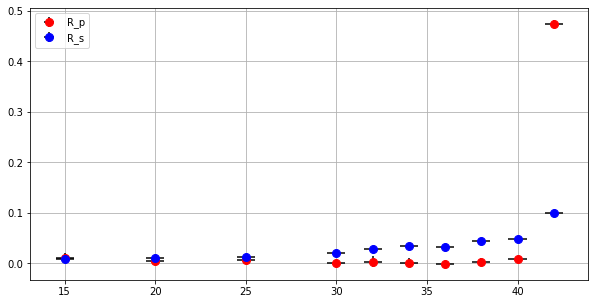

In [12]:
#Sketch
fig, ax = plt.subplots(figsize=(10,5))
plt.errorbar(x=df_p_r_corr['Angle_small'],y=df_p_r_corr['Coff'],
             fmt='o',mfc='r',mec='r',ms=8,
             xerr=df_p_r_corr['Angle_alpha'],yerr=df_p_r_corr['Err_Coff'], 
             ecolor='k',label='R_p')

plt.errorbar(x=df_s_r_corr['Angle_small'],y=df_s_r_corr['Coff'],
             fmt='o',mfc='b',mec='b',ms=8,
             xerr=df_s_r_corr['Angle_alpha'],yerr=df_s_r_corr['Err_Coff'], 
             ecolor='k',label='R_s')
ax.grid()
ax.legend()

In [13]:
#Samlet DF
Final_df = df_p_t_corr[['Angle_small','Angle_big','Angle_alpha']].copy()
Final_df['Angle_big_t'] = df_p_t_corr['Angle_big']
Final_df['Angle_big_r'] = df_p_r_corr['Angle_big']
Final_df['Coff_Rp'] = df_p_r_corr['Coff']
Final_df['Coff_Rp_err'] = df_p_r_corr['Err_Coff']
Final_df['Coff_Rs'] = df_s_r_corr['Coff']
Final_df['Coff_Rs_err'] = df_s_r_corr['Err_Coff']

Final_df['Coff_Tp'] = df_p_t_corr['Coff']
Final_df['Coff_Tp_err'] = df_p_t_corr['Err_Coff']
Final_df['Coff_Ts'] = df_s_t_corr['Coff']
Final_df['Coff_Ts_err'] = df_s_t_corr['Err_Coff']

Final_df.to_csv('Samlet_glas_til_luft_df.csv', index=False)